In [38]:
import torch
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image
from dataset import PigPenDataset

In [39]:
dataset = PigPenDataset(data_dir_path="../data", images=True)

In [43]:
import numpy as np
from PIL import Image

import matplotlib.colors as mcolors
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure

def get_cmap(cm="jet", N=256):
    colors = getattr(plt.cm, cm)(np.linspace(0,1,N))
    transparent_hot_colors = []
    for c, t in zip(colors, np.linspace(0,1,N)):
        transparent_hot_colors.append(c)
        transparent_hot_colors[-1][-1] = t
    return mcolors.LinearSegmentedColormap.from_list('hot', transparent_hot_colors, N=N)

def calculate_attention_weights_per_pixel(bboxes, scores):
    attention_weights = torch.zeros(384, 640, 1)
    for box, score in zip(bboxes, scores):
        x_min, y_min, x_max, y_max = box
        attention_weights[y_min:y_max, x_min:x_max] += score
    return attention_weights


def imshow_with_attention_overlay(ax, image, bboxes, scores):
    attention_weights = calculate_attention_weights_per_pixel(bboxes, scores)
    ax.imshow(image)
    ax.imshow(attention_weights, cmap=get_cmap())
    
    
def turn_off_axis(ax):
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
def plot_effect_grid(images, bboxes, scores, objects):
    dpi = 100
    sizes = np.shape(images[0])
    fig, axs  = plt.subplots(2,2, figsize=((sizes[1]/dpi)*2, (sizes[0]/dpi)*2), dpi=dpi)
    canvas = FigureCanvas(fig)
    caption_dict = {0: "Before", 1: "After"}
    for i in range(2):
        for o in range(2):
            if i == 0:
                axs[i][o].set_title(f"{objects[0]}")
            if o == 0:
                axs[i][o].set_ylabel(caption_dict[i])

            turn_off_axis(axs[i][o])
            imshow_with_attention_overlay(axs[i][o], images[i], bboxes[i], scores[i][o])

    plt.subplots_adjust(wspace=0, hspace=0)

    canvas.draw()

    image_from_plot = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    image_from_plot = image_from_plot.reshape(canvas.get_width_height()[::-1] + (3,))
    
    return image_from_plot



In [44]:
images, bboxes = dataset.get_images_and_bounding_boxes(0)
scores = torch.randn(2, 2, 100).softmax(-1)
arr = plot_effect_grid(images, bboxes, scores, ["a", "B"])
# scores.shape


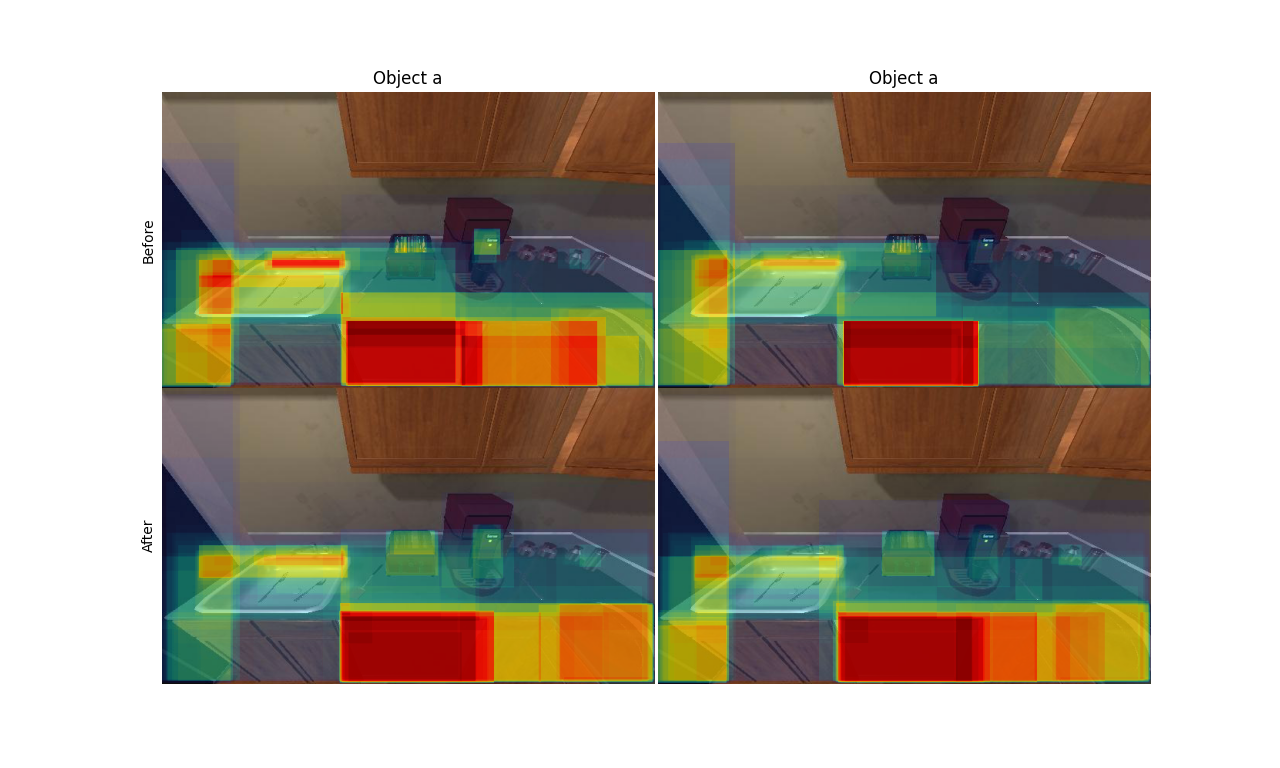

In [45]:
im = Image.fromarray(arr)
im